## Import

In [2]:
import seaborn as sns;
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as TTS
from sklearn.model_selection import cross_val_score;
from sklearn.preprocessing import LabelEncoder;
from sklearn.ensemble import RandomForestClassifier

# pipeline elements
from sklearn.decomposition import PCA # PCA = Principal Component Analysis
from sklearn.neighbors import KNeighborsClassifier as KNN 

# pipeline materiaux
from sklearn.pipeline import Pipeline # PCA = Principal Component Analysis
from sklearn.model_selection import GridSearchCV

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from itertools import cycle


## Collecte de données

In [3]:
# charger le dataset
fd = pd.read_csv('data/Fraud_Data.csv')
ip = pd.read_csv('data/IpAddress_to_Country.csv')

In [4]:
fd.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [5]:
ip.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [6]:
ip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [7]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [8]:
fd.dropna()
ip.dropna()
#ip.query("(country == 'China')")

,lower_bound_ip_address,upper_bound_ip_address,country
0,1.677722e+07,16777471,Australia
1,1.677747e+07,16777727,China
2,1.677773e+07,16778239,China
3,1.677824e+07,16779263,Australia
4,1.677926e+07,16781311,China
...,...,...,...
138841,3.758092e+09,3758093311,Hong Kong
138842,3.758093e+09,3758094335,India
138843,3.758095e+09,3758095871,China
138844,3.758096e+09,3758096127,Singapore


In [9]:
# On va parcourir le nombre de ligne contenu dans la dataset fd
# Si l'adresse ip contenu dans la data ip se trouve dans une des plages d'ip de la dataset de fd,
# stocke la ligne dans une variable. Si la ligne est bonne, créé des variable et les ajoute les colonnes en plus 
# des lignes correspondants dans fd.
#
# var: 
#         ligne: va stocker la ligne de l'ip se situant dans la plage d'adresse ip qui nous interesse
#         cou: va stocker le pays par rapport à la l'adresse ip récupéré
#         low: va stocker le lower_bound_ip_address par rapport à la l'adresse ip récupéré
#         up: va stocker le upper_bound_ip_address par rapport à la l'adresse ip récupéré


# Créer une list de la taille de fd
country = len(fd) * [0]                
lower_bound_ip_address = len(fd) * [0]
upper_bound_ip_address = len(fd) * [0]

for ind, row in fd.iterrows():          # Il va parcourir le nombre de ligne contenu dans fd
    ligne = ip[(ip['lower_bound_ip_address'] < row['ip_address']) &              
           (ip['upper_bound_ip_address'] > row['ip_address'])]       
    cou = ligne['country']  
    low = ligne['lower_bound_ip_address']  
    up = ligne['upper_bound_ip_address']  
    
    if len(cou) == 1:                   
        country[ind] = cou.values[0]  
        lower_bound_ip_address[ind] = low.values[0]  
        upper_bound_ip_address[ind] = up.values[0]

fd['country'] = country
fd['lower_bound_ip_address'] = lower_bound_ip_address
fd['upper_bound_ip_address'] = upper_bound_ip_address

In [10]:
fd.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,lower_bound_ip_address,upper_bound_ip_address
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,7.298089e+08,734003199
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,3.355443e+08,352321535
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,2.621440e+09,2621505535
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,0,0.000000e+00,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4.154982e+08,415629311


In [11]:
fd['ip_address'].max()

4294850499.6788397

In [12]:
fd['upper_bound_ip_address'].max()

3758063615

In [13]:
fd.to_csv('data/IpAddress_to_Country_Fraud_Data.csv') # On créé un fichier csv avec toutes nos données

In [14]:
fd_ip = pd.read_csv('data/IpAddress_to_Country_Fraud_Data.csv')

In [15]:
# On enlève les valeurs abérrante, en l'occurence les adresse ip qui n'appartiennent à aucune plage d'adresse ip

fd_ip = fd_ip[fd_ip.country != '0']

In [16]:
fd_ip

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,lower_bound_ip_address,upper_bound_ip_address
0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,7.298089e+08,734003199
1,1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,3.355443e+08,352321535
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,2.621440e+09,2621505535
4,4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4.154982e+08,415629311
5,5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada,2.809266e+09,2809331711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151106,151106,360761,2015-02-10 06:39:44,2015-06-03 08:18:30,13,EFCFFMUKFRDHJ,SEO,Safari,F,42,8.740657e+08,0,United States,8.724152e+08,889192447
151107,151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3.451155e+09,1,United States,3.451126e+09,3451387903
151108,151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,0,Netherlands,2.436039e+09,2441084927
151109,151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,0,Japan,2.748449e+09,2748514303


## Feature Engineering

In [17]:
Y = fd_ip['class'].astype('category').cat.codes # On veut afficher le type de fleur
X = fd_ip.drop('class', axis='columns') # On garde que les dimension de la fleur

In [18]:
X['source'] = LabelEncoder().fit_transform(X['source'])
X['browser'] = LabelEncoder().fit_transform(X['browser'])
X['sex'] = LabelEncoder().fit_transform(X['sex'])
X['country'] = LabelEncoder().fit_transform(X['country'])

In [19]:
X.shape, Y.shape

((129146, 14), (129146,))

In [20]:
# On supprime les colonnes qui nous intéresse pas

X = X.drop(['device_id'],axis=1)
X = X.drop(['signup_time'],axis=1)
X = X.drop(['purchase_time'],axis=1)
X = X.drop(['Unnamed: 0'],axis=1)
# X = X.drop(['country'],axis=1)
# X = X.drop(['upper_bound_ip_address'],axis=1)
# X = X.drop(['lower_bound_ip_address'],axis=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129146 entries, 0 to 151110
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   user_id                 129146 non-null  int64  
 1   purchase_value          129146 non-null  int64  
 2   source                  129146 non-null  int32  
 3   browser                 129146 non-null  int32  
 4   sex                     129146 non-null  int32  
 5   age                     129146 non-null  int64  
 6   ip_address              129146 non-null  float64
 7   country                 129146 non-null  int32  
 8   lower_bound_ip_address  129146 non-null  float64
 9   upper_bound_ip_address  129146 non-null  int64  
dtypes: float64(2), int32(4), int64(4)
memory usage: 8.9 MB


In [21]:
X

,user_id,purchase_value,source,browser,sex,age,ip_address,country,lower_bound_ip_address,upper_bound_ip_address
0,22058,34,2,0,1,39,7.327584e+08,84,7.298089e+08,734003199
1,333320,16,0,0,0,53,3.503114e+08,171,3.355443e+08,352321535
2,1359,15,2,3,1,53,2.621474e+09,171,2.621440e+09,2621505535
4,221365,39,0,4,1,45,4.155831e+08,171,4.154982e+08,415629311
5,159135,42,0,0,1,18,2.809315e+09,32,2.809266e+09,2809331711
...,...,...,...,...,...,...,...,...,...,...
151106,360761,13,2,4,0,42,8.740657e+08,171,8.724152e+08,889192447
151107,345170,43,2,0,1,28,3.451155e+09,171,3.451126e+09,3451387903
151108,274471,35,2,4,1,32,2.439047e+09,118,2.436039e+09,2441084927
151109,368416,40,2,2,0,26,2.748471e+09,84,2.748449e+09,2748514303


## Entrainer un model

In [22]:
clf = RandomForestClassifier(random_state=0)

In [23]:
X_tr, X_te, Y_tr, Y_te = TTS(X, Y,              # features, target
                            stratify = Y,       # Va prendre une proportion aux hasard de valeurs différentes histoire de ne pas avoir des cas où l'on a que des même valeur
                            random_state=777,   # Sert à fixer le harsard pour ne pas avoir des résultat différents à chaque tests.
                            train_size=0.8)     # 50% de X_train et Y_train et 50% de Y_test et Y_test

In [24]:
clf.fit(X_tr, Y_tr)

RandomForestClassifier(random_state=0)

In [25]:
clf.predict(X_te)

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [26]:
clf.predict_proba(X_te)

array([[0.9 , 0.1 ],
       [0.98, 0.02],
       [0.96, 0.04],
       ...,
       [0.94, 0.06],
       [0.92, 0.08],
       [0.94, 0.06]])

In [27]:
predictions = clf.predict(X_te)

In [28]:
accuracy = lambda p,y: (p==y).sum()/p.shape[0] # Notre fonction de précision

In [29]:
# On cherche à prédir X_tr par rapport à Y_tr

knn = KNN(n_neighbors=3)
knn.fit(X_tr, Y_tr)
train_preds = knn.predict(X_te)
"TEST ACCURACY: ", accuracy(predictions, Y_te)

('TEST ACCURACY: ', 0.9464576074332172)

In [30]:
train_preds = knn.predict(X_tr)
"TRAIN ACCURACY: ", accuracy(train_preds, Y_tr)

('TRAIN ACCURACY: ', 0.9417224824809323)

## Confusion matrix

In [31]:
X_te.shape, Y_te.shape, X_tr.shape, Y_tr.shape

((25830, 10), (25830,), (103316, 10), (103316,))

In [32]:
# Matrice de confusion 
#
# la matrice de confusion est une matrice qui mesure la qualité d'un système de classification. 
# Chaque ligne correspond à une classe réelle, chaque colonne correspond à une classe estimée. 

(train_preds, Y_tr)
(predictions, Y_te)

from sklearn.metrics import confusion_matrix

labels = range(2)                                             # Equivaut aux valeurs que peut retourner la target
cm_train = confusion_matrix(train_preds, Y_tr, labels=labels)
cm_test = confusion_matrix(predictions, Y_te, labels=labels)

In [33]:
Y.unique()

array([0, 1], dtype=int8)

In [34]:
labels

range(0, 2)

In [35]:
def show_cm(cm, labels):
    df_cm = pd.DataFrame(cm, labels, labels)
    sns.heatmap(df_cm, annot=True)
    plt.show()

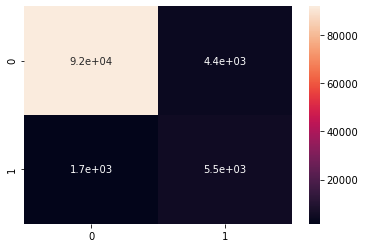

In [36]:
show_cm(cm_train, labels)

In [37]:
cm_train

array([[91841,  4360],
       [ 1661,  5454]], dtype=int64)

In [38]:
cm_test

array([[23247,  1254],
       [  129,  1200]], dtype=int64)

## Feature Importance

In [39]:
# L'importance permet de connaitre l'importance d'une colonne
# par rapport aux autres colonnes.

clf.fit(X_tr, Y_tr)                       # On re-train nos valeurs
importance = clf.feature_importances_   
importance

array([0.15433073, 0.12961673, 0.03024079, 0.03044873, 0.02160526,
       0.11143173, 0.18905858, 0.05768799, 0.13782875, 0.13775071])

In [40]:
# On renomme nos colonnes

name = X_tr.columns.tolist()
name = np.char.replace(name, 'lower_bound_ip_address', 'lower_bound_ip_addr')
name = np.char.replace(name, 'upper_bound_ip_address', 'upper_bound_ip_addr')

Features:

   user_id: (18.905858)
   purchase_value: (15.433073)
   source: (13.782875)
   browser: (13.775071)
   sex: (12.961673)
   age: (11.143173)
   ip_address: (5.768799)
   country: (3.044873)
   lower_bound_ip_address: (3.024079)
   upper_bound_ip_address: (2.160526)


<Figure size 432x288 with 0 Axes>

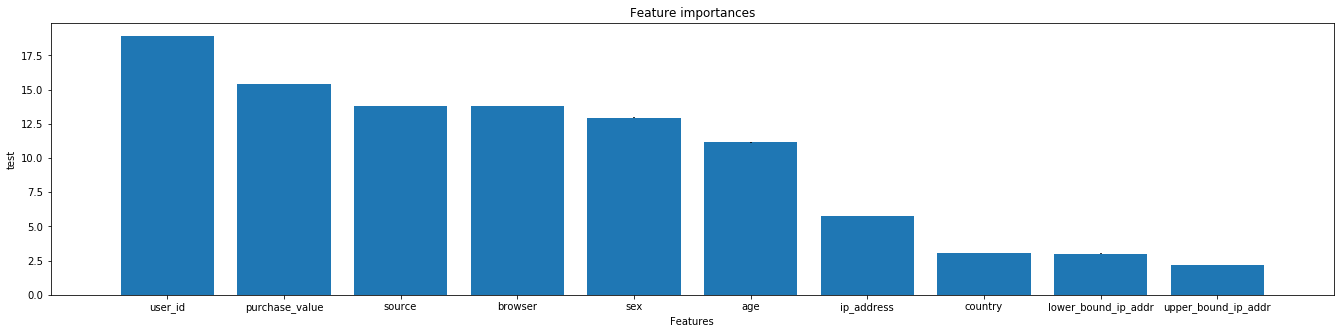

In [41]:
# On souhaite Afficher dans un graphique notre importance

std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importance)[::-1]

# Affichage de nos features avec leur pourcentage
print("Features:")
print()

for f in range(X.shape[1]):
    print("   %s: (%f)" % (X_tr.columns[f], importance[indices[f]]*100))

# Affichage de notre Features importance
plt.figure()
plt.subplots(figsize=(23,5))                                              #Taille de la figure
plt.title("Feature importances")
plt.xlabel('Features')
plt.ylabel('test')
plt.bar(name, importance[indices]*100, yerr=std[indices], align="center") # Valeur en X, Hauteur, Largeur, alignement
plt.xlim([-1, X.shape[1]])                                                # Limite de l'axe X
plt.show()

## Affichage du nombre de faudres

In [ ]:
# L'objectif est d'afficher le Nombre d'attaque en fonction des pays
# On affichera uniquement les 10 pays les plus attaqué

fd_ip_wo_class0 = fd_ip[fd_ip['class'] == 1]              # On s'interessera qu'au fraude qui on eu lieu
country_by_class = pd.DataFrame()                         # On crée un nouveau dataframe
country_by_class['country'] = fd_ip['country']            # On ajoute à notre dataset la colonne country
country_by_class['class'] = fd_ip['class']                # On ajoute à notre dataset la colonne classe
total = country_by_class.groupby(by="country",as_index=False).sum().sort_values(by='class', ascending=False) # On groupe tout nos country en en fonction de la somme de nos class par ordre décroissant

total.head(10)                                            # On affiche le total


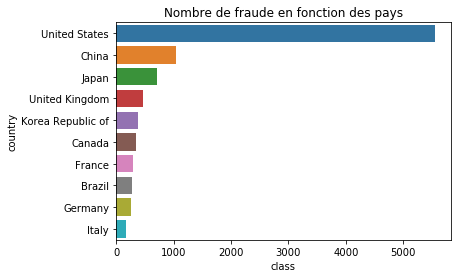

In [132]:
df = total.head(10)

sns.barplot(df['class'], df['country']).set_title("Nombre de fraude en fonction des pays");

## Conclusion

En conclusion, nous ne pouvons pas stopper les fraudes mais il y a des moyens de les détecter plus facilement. En effet, la précision des prédictions de nos features sur la target étant de 94%, nous pouvons affirmer avec cette même probabilité que certaines features sont plus utiles que d'autres comme la feature adresses ip ou purchase value. L'adresse IP et le purchase value soit la quantité d'argent que l'utilisateur a dépensé sont des features qui nous permettent de détecter plus facilement les frauders. Après, nous pouvons également voir que selon le pays, le nombre de fraude est plus élevé et nécessite alors beaucoup plus de mesure que dans d'autres pays. En l'occurrence, parmi tous les pays, l'Amérique est de loin le pays le plus touché par les attaques informatiques.

In [44]:
# Binarize the output
Y = label_binarize(Y, classes=[0, 1, 2])
n_classes = Y.shape[1]

In [45]:
# Binarize the output
Y = label_binarize(Y, classes=[0, 1, 2])
n_classes = Y.shape[1]

In [46]:
# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

In [48]:
splits = TTS(X, Y,           # features, target
                         train_size=0.3,  # 50% de X_train et Y_train et 50% de Y_test et Y_test
                         stratify=Y,      # Va prendre une proportion aux hasard de valeurs différentes histoire de ne pas avoir des cas où l'on a que des même valeur
                         random_state=1203)  # Sert à fixer le harsard pour ne pas avoir des résultat différents à chaque tests.

In [49]:
# shuffle and split training and test sets
X_train, X_test, Y_train, Y_test = splits #On associe chaque shape à une variable

In [ ]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))

Y_score = classifier.fit(X_train, Y_train).decision_function(X_test)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


In [ ]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()